In [ ]:
!pip install torch==1.0.0 torchvision==0.2.1

     |████████████████████████████████| 61kB 6.3MB/s 
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [ ]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from tqdm import tqdm
from math import ceil

import torch
from torch import nn
import torch.nn.functional as F
# from torchvision import datasets, models, transforms
# import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
torch.__version__

'1.0.0'

In [ ]:
%pwd

'/content'

In [ ]:
%mkdir drive/My\ Drive/mobile_net

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Loading data

In [ ]:
DATA = np.load('/content/drive/My Drive/daataa/training_data_rgb.npy', allow_pickle=True)
DATA.shape

(66431, 2)

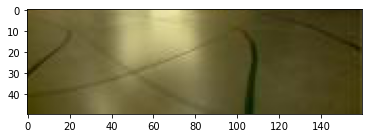

In [ ]:
plt.imshow(DATA[8000][0], cmap='gray')

In [ ]:
# first 8k samples are corrupted
# 
DATA = DATA[8000:]
DATA.shape

(58431, 2)

In [ ]:
X, Y = [], []

for x, y in DATA:
    X.append(x)
    Y.append(y)

In [ ]:
X = np.array(X, dtype=np.float16)
Y = np.array(Y, dtype=np.float16)

X.shape, Y.shape

((58431, 50, 160, 3), (58431,))

In [ ]:
# normalization

X /= 255

In [ ]:
img_shape = X[0].shape

X = np.concatenate(X).reshape(-1, *img_shape)
X.shape

(58431, 50, 160, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
      X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((46744, 50, 160, 3), (11687, 50, 160, 3))

# 2. In memory dataloader

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """
    __initialized = False
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset)), leave=True, position=0):
            batch = [torch.tensor(t).to(device) for t in dataset[i]]
            batches.append(batch)
        tensors = [
            torch.stack(ts) for ts in zip(*batches)
        ]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
batch_size = 128

# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])


data_loaders = {
    'train': InMemDataLoader(
        list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True),
    'test': InMemDataLoader(
        list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)
}

100%|██████████| 11687/11687 [00:01<00:00, 7698.52it/s]


# 3. CNN class

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        kernel = (3, 3)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=kernel, stride=(2, 2), bias=False),
            nn.ELU(alpha=1.0),
            nn.Conv2d(24, 48, kernel_size=kernel, stride=(2, 2), bias=False),
            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1)),
            nn.Dropout(p = 0.25)
        )
        self.linear = nn.Sequential(
            nn.Linear(864, 50),
            nn.ELU(alpha=1.0),
            nn.Linear(50, 10),
            nn.Linear(10, 1),
        )
        

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        loss = torch.sum((Out - Targets) ** 2)
        return loss / Out.size(0)

# 4. Mobile Net

In [ ]:
import torchvision.models as models

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        mobilenet = models.mobilenet_v2(pretrained=True)

        for param in mobilenet.parameters():
            param.requires_grad = False

        mobilenet.eval()

        kernel = (3, 3)
        self.conv = nn.Sequential(
            Mobile_Net,
        )
        self.linear = nn.Sequential(
            nn.Linear(864, 50),
            nn.ELU(alpha=1.0),
            nn.Linear(50, 10),
            nn.Linear(10, 1),
        )
        

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        loss = torch.sum((Out - Targets) ** 2)
        return loss / Out.size(0)

ImportError: ignored

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.torch/hub/v0.6.0.zip

FileNotFoundError: ignored

# 5. CNN Training

In [ ]:
l_rate = 0.001
n_epochs = 1000
n_batches_train = ceil(X_train.shape[0] / batch_size)
n_batches_test = ceil(X_test.shape[0] / batch_size)

In [ ]:
model = CNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

model

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=(1, 1), ceil_mode=False)
    (4): Dropout(p=0.25)
  )
  (linear): Sequential(
    (0): Linear(in_features=864, out_features=50, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
loss_arr = []
epoch = 579 # act epoch
best_valid_loss = 1e9

In [ ]:
# Loading previous loss

loss_arr = np.load(f'drive/My Drive/donkey_model4/loss{epoch}.npy', allow_pickle=True)
best_valid_loss = np.min(loss_arr[:, 1])
loss_arr = list(loss_arr)
len(loss_arr)

577

In [ ]:
# Loading previous model

model.load_state_dict(torch.load(f'drive/My Drive/donkey_model4/{epoch}.tch'))

In [ ]:
model.train()
model.to(device)

for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
            
patience_expansion = 5
with_tqdm = True

if with_tqdm:
    pbar = tqdm(total=n_epochs, desc='Training', position=0, leave=True)
    pbar.update(epoch)

try:
    while epoch < n_epochs:
        epoch += 1
        if with_tqdm:
            pbar.update(1)
        model.train()

        training_loss = 0
        for images, y in data_loaders['train']:
            y = y.reshape(-1, 1)

            a, b, c, d = images.size()
            images = images.reshape(a, d, b, c)

            z = model(images.float())
            loss = model.loss(z.float(), y.float())
            training_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_loss /= n_batches_train
    
        model.eval()
        
        valid_loss = 0
        with torch.no_grad():
            for images, y in data_loaders['test']:
                images = images.to(device)
                y = y.to(device).reshape(-1, 1)

                a, b, c, d = images.size()
                images = images.reshape(a, d, b, c)

                z = model(images.float())
                loss = model.loss(z.float(), y.float())

                valid_loss += loss
         
        valid_loss /= n_batches_test
        # clear_output(True)
        if not with_tqdm:
            print(f'Epoch: {epoch}/{n_epochs} | Training loss: {training_loss :.4f} | Val loss: {valid_loss :.4f}')
        
        loss_arr.append((training_loss, valid_loss))
        
        if valid_loss < best_valid_loss:
            # Adjust num of epochs
            n_epochs = int(np.maximum(n_epochs, epoch * patience_expansion + 1))
            best_valid_loss = valid_loss
            if with_tqdm:
                pbar.total = n_epochs
                # pbar.desc = f'Training (best {best_valid_loss :.4})'
                # pbar.refresh()
        
            torch.save(model.state_dict(), f'drive/My Drive/donkey_model4/{epoch}.tch')
            np.save(f'drive/My Drive/donkey_model4/loss{epoch}.npy', np.array(loss_arr))

        if with_tqdm:
            pbar.desc = f'Training (best: {best_valid_loss :.4} | cur: {valid_loss :.4})'
            pbar.refresh()
    
except KeyboardInterrupt:
    pass

if with_tqdm:
    pbar.close()

Training:  21%|██        | 1188/5681 [00:09<00:35, 126.46it/s]


In [ ]:
torch.save(model.state_dict(), f'drive/My Drive/donkey_model4/final_model.tch')

In [ ]:
np.save(f'drive/My Drive/donkey_model4/final_loss.npy', np.array(loss_arr))

## Loss

In [ ]:
# save final loss

final_loss = [(x.detach().cpu(), y.detach().cpu()) for x, y in loss_arr]
final_loss = np.array(final_loss)

np.save(f'drive/My Drive/donkey_model4/final_loss.npy', final_loss)

In [ ]:
final_loss = np.load('drive/My Drive/donkey_model4/final_loss.npy', allow_pickle=True)

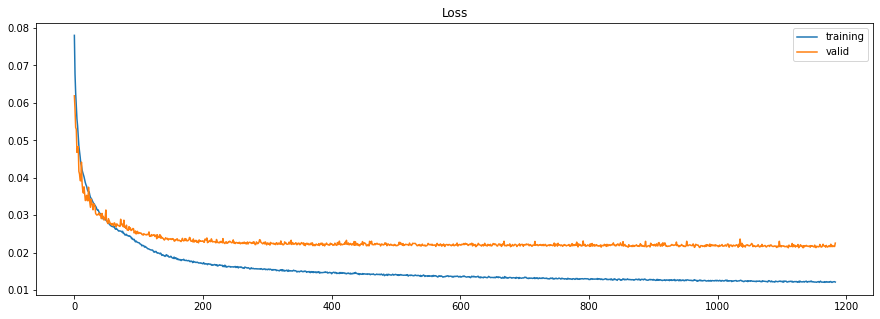

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(np.arange(len(final_loss)), final_loss[:, 0], label='training')
plt.plot(np.arange(len(final_loss)), final_loss[:, 1], label='valid')
plt.legend(loc='upper right')
# plt.ylim(0, 1)
plt.show()

# 6. Mobile Net training

In [ ]:
l_rate = 0.001
n_epochs = 1000
n_batches_train = ceil(X_train.shape[0] / batch_size)
n_batches_test = ceil(X_test.shape[0] / batch_size)

In [ ]:
model = MobileNet()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

model

AttributeError: ignored